In [24]:
import json
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
from shapely.ops import linemerge
from tqdm import tqdm

display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
plt.style.use("dark_background")

In [25]:
root_dir = ".."

In [26]:
admin = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
admin.geometry = admin.geometry.boundary
admin.geometry = admin.geometry.simplify(tolerance=0.1)

In [27]:
edges = gpd.read_parquet(os.path.join(root_dir, "results/flow_allocation/edges_with_flows.gpq"))

In [41]:
edges.sort_values("volume_tons", ascending=False).head(20)

,from_id,to_id,from_iso_a3,to_iso_a3,mode,cost_USD_t,geometry,value_kusd,volume_tons
339294,port1021_land,GID_0_USA,USA,USA,imaginary,1000000.000000,"LINESTRING (-130.33776 54.26668, -99.70229 37....",6.072152e+07,1.652292e+07
335338,port752_in,port752_out,JPN,JPN,maritime,0.000000,None,6.072152e+07,1.652292e+07
334551,port752_out,port1021_in,JPN,USA,maritime,13.623012,"LINESTRING (133.72429 34.50033, 132.60001 34.2...",6.072152e+07,1.652292e+07
336465,port1021_in,port1021_land,USA,USA,maritime,0.000000,None,6.072152e+07,1.652292e+07
325168,port1127_out,port610_in,JPN,JPN,maritime,0.736757,"LINESTRING (132.56522 34.22708, 132.60001 34.2...",5.807258e+07,1.554862e+07
335356,port1127_in,port1127_out,JPN,JPN,maritime,0.000000,None,5.807258e+07,1.554862e+07
325730,port610_out,port752_in,JPN,JPN,maritime,0.626449,"LINESTRING (132.56522 34.22708, 132.60001 34.2...",5.807258e+07,1.554862e+07
335330,port610_in,port610_out,JPN,JPN,maritime,0.000000,None,5.807258e+07,1.554862e+07
315100,port1197_out,port1127_in,THA,JPN,maritime,11.694311,"LINESTRING (100.89999 13.08873, 100.39999 12.9...",5.807258e+07,1.554862e+07
335861,port1197_in,port1197_out,THA,THA,maritime,0.000000,None,4.411823e+07,1.195559e+07


Text(0, 0.5, 'Frequency')

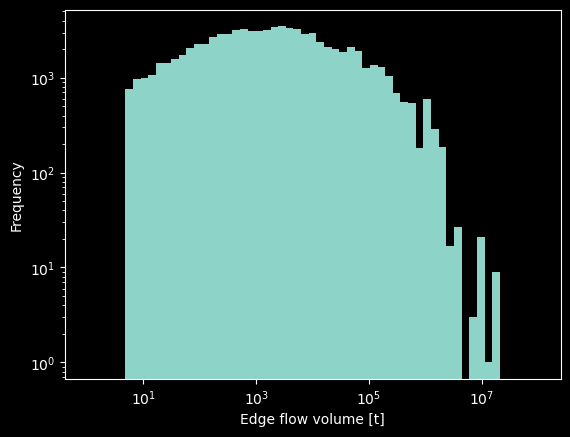

In [29]:
f, ax = plt.subplots()
min_non_zero = edges[edges.volume_tons != 0].volume_tons.min()
min_base_10_exp = int(np.floor(np.log10(min_non_zero)))
max_base_10_exp = int(np.ceil(np.log10(edges.volume_tons.max())))
ax.hist(
    edges.volume_tons,
    bins=np.logspace(
        min_base_10_exp,
        max_base_10_exp,
        60
    )
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Edge flow volume [t]")
ax.set_ylabel("Frequency")

       volume_t_km
mode              
rail  3.434760e+07
road  7.768186e+10


Text(0, 0.5, 'Volume [t] / Distance [km]')

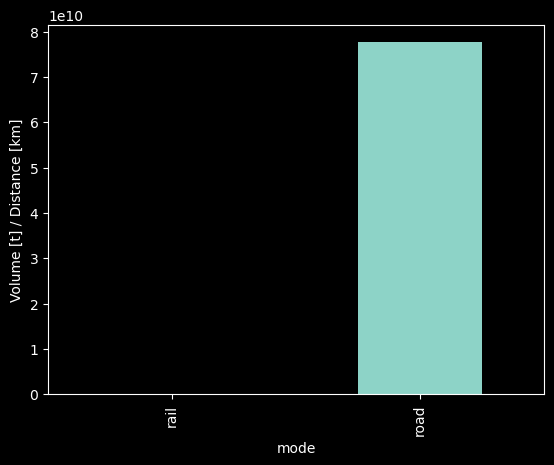

In [30]:
land_mask = edges["mode"].isin(("road", "rail"))
land = edges.loc[land_mask].copy()
land["distance_km"] = land["geometry"].to_crs(land.estimate_utm_crs()).length / 1000
land["volume_t_km"] = land.volume_tons / land.distance_km

modal_split = land.loc[:, ["volume_t_km"]].groupby(land["mode"]).sum()
print(modal_split)
f, ax = plt.subplots()
modal_split.volume_t_km.plot(kind="bar", ax=ax)
ax.set_ylabel("Volume [t] / Distance [km]")

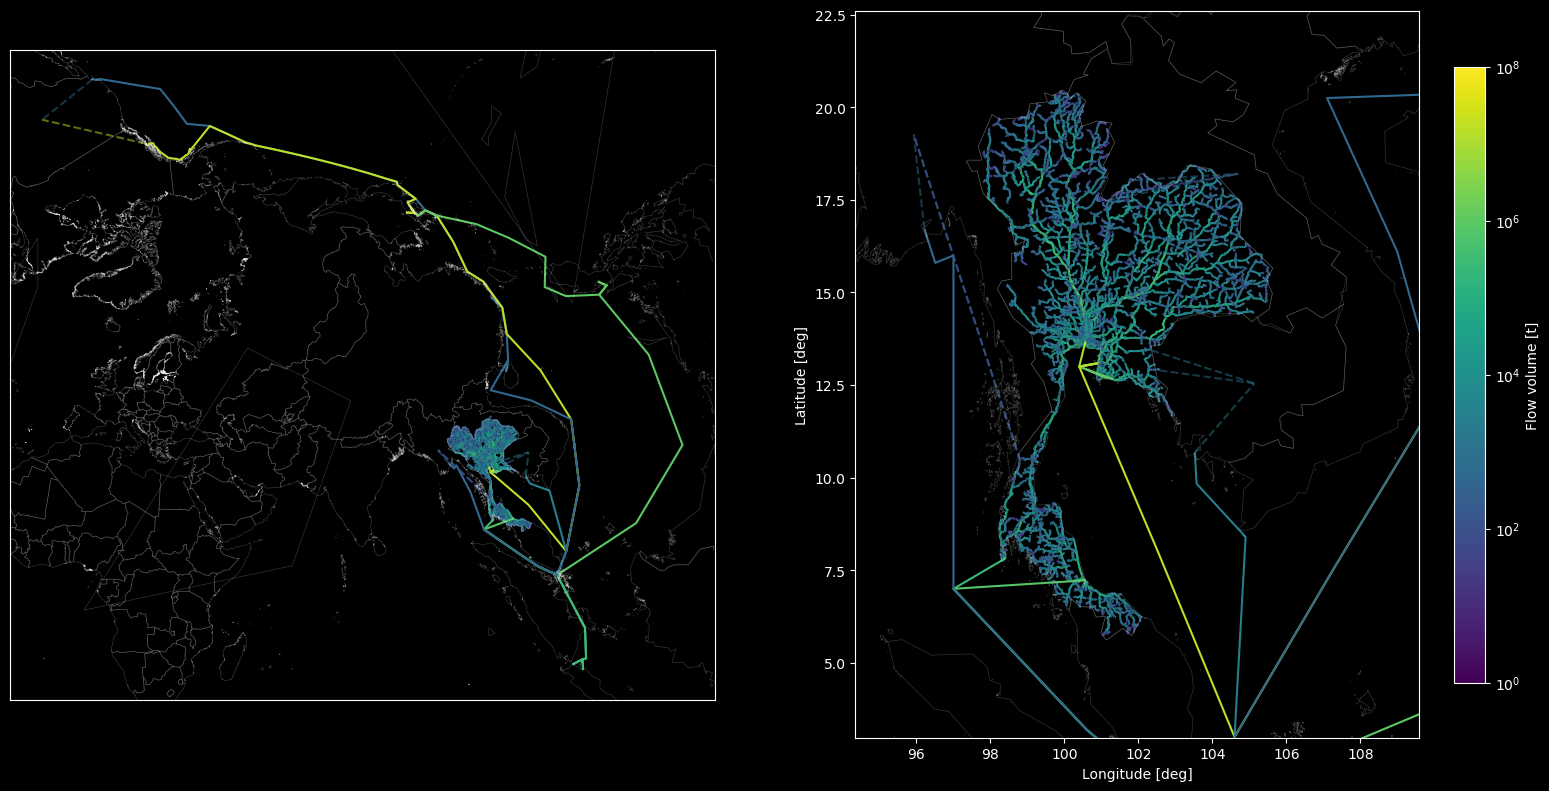

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 16))

to_plot = edges[edges.volume_tons != 0]
not_imaginary_mask = to_plot["mode"] != "imaginary"

norm = LogNorm(10**min_base_10_exp, 10**max_base_10_exp)
orthographic_proj: int = 9840

to_plot[not_imaginary_mask].to_crs(epsg=orthographic_proj).plot("volume_tons", ax=ax1, norm=norm)
to_plot[~not_imaginary_mask].to_crs(epsg=orthographic_proj).plot("volume_tons", ax=ax1, norm=norm, ls="--", alpha=0.5)
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
admin.to_crs(epsg=orthographic_proj).plot(ax=ax1, lw=0.5, alpha=0.2)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

to_plot[not_imaginary_mask].plot("volume_tons", ax=ax2, legend=True, norm=norm, legend_kwds={"shrink": 0.5, "label": "Flow volume [t]"})
to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax2, norm=norm, ls="--", alpha=0.5)
admin.plot(ax=ax2, lw=0.5, alpha=0.2)
ax2.set_xlim(94.35, 109.59)
ax2.set_ylim(2.98, 22.59)
ax2.set_xlabel("Longitude [deg]")
ax2.set_ylabel("Latitude [deg]")
f.savefig("trade_flow_allocation.png")

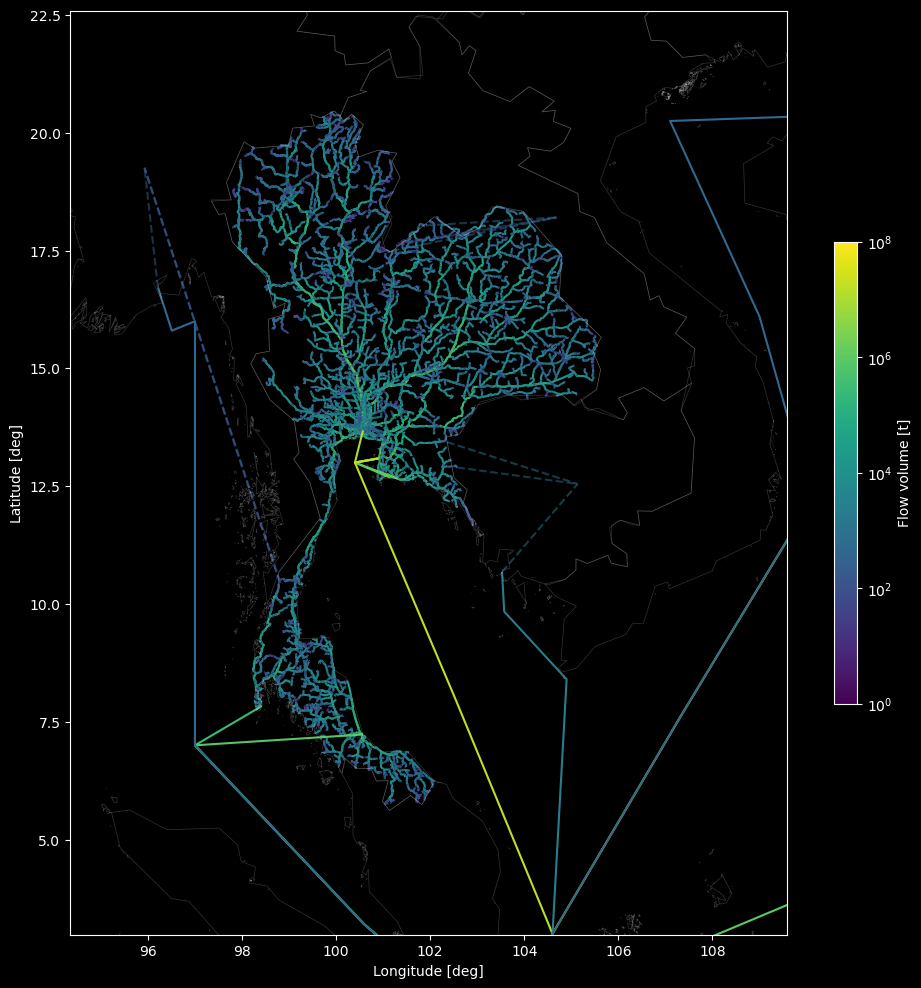

In [32]:
f, ax2 = plt.subplots(figsize=(12, 12))

to_plot = edges[edges.volume_tons != 0]
not_imaginary_mask = to_plot["mode"] != "imaginary"

norm = LogNorm(10**min_base_10_exp, 10**max_base_10_exp)
orthographic_proj: int = 9840

to_plot[not_imaginary_mask].plot("volume_tons", ax=ax2, legend=True, norm=norm, legend_kwds={"shrink": 0.5, "label": "Flow volume [t]"})
to_plot[~not_imaginary_mask].plot("volume_tons", ax=ax2, norm=norm, ls="--", alpha=0.5)
admin.plot(ax=ax2, lw=0.5, alpha=0.2)
ax2.set_xlim(94.35, 109.59)
ax2.set_ylim(2.98, 22.59)
ax2.set_xlabel("Longitude [deg]")
ax2.set_ylabel("Latitude [deg]")
f.savefig("trade_flow_allocation_local.png")

In [43]:
routes_path = os.path.join(root_dir, "results/flow_allocation/routes.json")
with open(routes_path, "r") as fp:
    routes_with_edge_indicies: dict = json.load(fp)

cost_col_id = edges.columns.get_loc("cost_USD_t")
#geometry_col_id = edges.columns.get_loc("geometry")
routes_with_geometry = []
for source_node, destination_nodes in tqdm(routes_with_edge_indicies.items()):
    for destination_node, route_data in destination_nodes.items():
        # drop edges missing geometry (we expect these for within port connections
        #route_edge_geometry = edges.iloc[route_data["edge_indicies"], geometry_col_id].dropna()
        #route_linestring = linemerge(list(route_edge_geometry))
        cost_USD_t = edges.iloc[route_data["edge_indicies"], cost_col_id].sum()
        if 1E6 < cost_USD_t < 2E6:
            cost_USD_t -= 1E6
        elif cost_USD_t == 0:
            pass
        else:
            print(cost_USD_t, source_node, destination_node)
            continue
        routes_with_geometry.append(
            (
                source_node,
                destination_node.split("_")[-1],
                route_data["value_kusd"],
                route_data["volume_tons"],
                cost_USD_t,
                #route_linestring
            )
        )

routes = pd.DataFrame(routes_with_geometry, columns=["source_node", "destination_node", "value_kusd", "volume_tons", "cost_USD_t"])#, "geometry"])
routes

 20%|████████████████▏                                                              | 10190/49819 [00:02<00:10, 3622.89it/s]

3000063.874345813 laos-latest_11_16 GID_0_USA
3000063.897870724 thailand-latest_30_1129 GID_0_USA
3000063.9210384567 thailand-latest_30_488 GID_0_USA
3000063.8763232706 thailand-latest_38_730 GID_0_USA


 71%|███████████████████████████████████████████████████████▊                       | 35210/49819 [00:08<00:03, 4303.22it/s]

3000027.8266853197 myanmar-latest_48_69 GID_0_USA
3000027.818991848 myanmar-latest_48_71 GID_0_USA
3000027.895930212 myanmar-latest_48_90 GID_0_USA
3000027.822923378 thailand-latest_10_955 GID_0_USA
3000027.8228703407 thailand-latest_10_956 GID_0_USA
3000027.8189410707 thailand-latest_10_957 GID_0_USA


 75%|███████████████████████████████████████████████████████████▌                   | 37548/49819 [00:09<00:02, 4274.08it/s]

3000026.30702245 thailand-latest_36_607 GID_0_USA


100%|███████████████████████████████████████████████████████████████████████████████| 49819/49819 [00:11<00:00, 4179.84it/s]

3000027.041598658 cambodia-latest_5_13 GID_0_USA


,source_node,destination_node,value_kusd,volume_tons,cost_USD_t
0,thailand-latest_14_1060,USA,34.590597,15.373800,75.511356
1,thailand-latest_14_1061,USA,138.206039,61.425709,75.509560
2,thailand-latest_14_1062,USA,279.078967,101.723355,75.323545
3,thailand-latest_14_1063,USA,620.486762,196.824068,75.164861
4,thailand-latest_14_1065,USA,14.831511,6.591869,75.505001
...,...,...,...,...,...
49802,thailand-latest_36_644,USA,624.407253,588.219564,43.992859
49803,thailand-latest_36_673,USA,337.370794,317.818380,44.109514
49804,thailand-latest_36_866,USA,611.084237,575.668687,44.016866
49805,thailand-latest_43_0,USA,105.291393,99.189202,42.363964


In [44]:
# we need at least the top 20 trading partners to get 90% of the trade volume
# here we only have 8 partners total (all in the top 20)
routes.loc[:, ["destination_node", "volume_tons"]].groupby("destination_node").sum().sort_values("volume_tons", ascending=False)

,volume_tons
destination_node,
USA,1.664046e+07


In [45]:
volume_tons_by_country = routes.loc[:, ["destination_node", "volume_tons"]].groupby("destination_node").sum()
volume_tons_by_country.index.name = "GID_0"
# country boundaries for diagnostic plotting
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))
volume_tons_by_country_with_geom = countries.set_index("GID_0", drop=True).join(volume_tons_by_country)

Text(0.5, 1.0, 'Partner country trade volume [t/a] post-allocation')

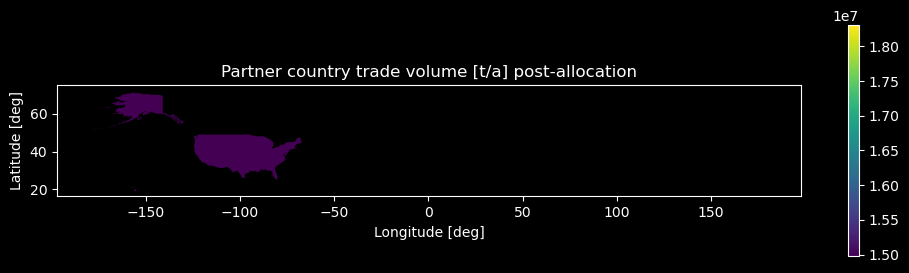

In [46]:
f, ax = plt.subplots(figsize=(12, 10))
volume_tons_by_country_with_geom.plot("volume_tons", ax=ax, legend=True, legend_kwds={"shrink": 0.3})
ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")
ax.set_title("Partner country trade volume [t/a] post-allocation")